# **Car Prices Prediction**


  ## **Introduction**

  The purpose of this project is to train and compare multiple regression models with the goal of predicting the price of used cars by knowing the following characteristics:

  * **Manufacturer**;
  * **Model**;
  * **Year**;
  * **Transmission**;
  * **Mileage**;
  * **Type of Fuel**;
  * **Miles per Gallon**;
  * **Engine Size**.

  The dataset considered contains about 40000 examples of used cars sold in the UK, provided through the CVS file 'car_prices.csv'.

  **N.B.:** The dataset is uploaded from Google Drive, so if you want to use the notebook you have to upload the dataset in advance.



## **Libraries**

Main libraries used are:
* **tensorflow**: enables the development and training of machine learning models focused on DNN;
* **keras**: used for semplify the training of the model;
* **sklearn**: supports supervised and unsupervised learning, provides various tools for preprocessing, model selection, model evaluation and many other utilities;
* **pandas**: Python library that provide data structures and functions to efficiently maanupulate data;
* **numpy**: Python library that provide data structures and function to efficiently work on large N-dimensional numerical array;
* **seaborn** and **matplotlib**: libraries used to visualize data and build graphs.

In [ ]:
import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.initializers import HeNormal, GlorotUniform
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error

from matplotlib import pyplot as plt

import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category = DeprecationWarning)

## **Utils Function**



The following function is used to plot the metrics through epochs.

In [ ]:
def plot_metrics(history):
    plt.figure(figsize=(14, 5))

    # Plot of loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    # Plot of MAE (Mean Absolute Error)
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mean_absolute_error'], label='Training MAE')
    plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.title('Mean Absolute Error Over Epochs')
    plt.legend()

    plt.show()


This function is used to evaluate the performance on the testing set and generate the scatter plot to observe the performance.

In [ ]:
def evaluate_performance(model, test_data, test_labels):
    loss, mae = model.evaluate(test_data, test_labels, verbose=0)
    print(f'Test Loss: {loss:.4f}')
    print(f'Test MAE: {mae:.4f}')

## **Loading the Dataset**

Load the dataset from Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)
dataset_path = 'drive/MyDrive/projectML/car_prices.csv'
data = pd.read_csv(dataset_path)
#data.head()

Mounted at /content/drive


Once the dataset is loaded, the column for the prices to predict is removed.

In [ ]:
#Dataset without price column
dataset = data.drop('price', axis = 1)
#dataset.head()

In [ ]:
#The price column to predict
prices = data['price']
#prices.head()

## **Dataset Preprocessing**

Before the dataset can be used, the issue of missing values or NaN data must be considered so as to have "clean" data.


In [ ]:
null_dataset = dataset.isnull().values.any()
null_prices = prices.isnull().values.any()

print('There are invalid entries inside the detaset.' if null_dataset else 'There are not invalid entries inside the dataset.')
print('There are invalid entries inside prices column.' if null_prices else 'There are not invalid entries inside prices column.')

There are not invalid entries inside the dataset.
There are not invalid entries inside prices column.


Consider the unique values present within the features of the dataset.

In [ ]:
manufacturer_unique_values = dataset['manufacturer'].unique()
model_unique_values = dataset['model'].unique()
transmission_unique_values = dataset['transmission'].unique()
type_of_fuel_unique_values = dataset['fuelType'].unique()

print("/---------------------------------------------------------------------------------------/\n")
print("Manufacturer Values:")
print(manufacturer_unique_values, "\n")
print("/---------------------------------------------------------------------------------------/\n")
print("Model Values:")
print(model_unique_values, "\n")
print("/---------------------------------------------------------------------------------------/\n")
print("Transmission Values:")
print(transmission_unique_values, "\n")
print("/---------------------------------------------------------------------------------------/\n")
print("Type of Fuel Values:")
print(type_of_fuel_unique_values, "\n")
print("/---------------------------------------------------------------------------------------/\n")

/---------------------------------------------------------------------------------------/

Manufacturer Values:
['Audi' 'BMW' 'Toyota' 'Mercedes'] 

/---------------------------------------------------------------------------------------/

Model Values:
[' A1' ' A6' ' A4' ' A3' ' Q3' ' Q5' ' A5' ' S4' ' Q2' ' A7' ' TT' ' Q7'
 ' RS6' ' RS3' ' A8' ' Q8' ' RS4' ' RS5' ' R8' ' SQ5' ' S8' ' SQ7' ' S3'
 ' S5' ' A2' ' RS7' ' 5 Series' ' 6 Series' ' 1 Series' ' 7 Series'
 ' 2 Series' ' 4 Series' ' X3' ' 3 Series' ' X5' ' X4' ' i3' ' X1' ' M4'
 ' X2' ' X6' ' 8 Series' ' Z4' ' X7' ' M5' ' i8' ' M2' ' M3' ' M6' ' Z3'
 ' GT86' ' Corolla' ' RAV4' ' Yaris' ' Auris' ' Aygo' ' C-HR' ' Prius'
 ' Avensis' ' Verso' ' Hilux' ' PROACE VERSO' ' Land Cruiser' ' Supra'
 ' Camry' ' Verso-S' ' IQ' ' Urban Cruiser' ' SLK' ' S Class' ' SL CLASS'
 ' G Class' ' GLE Class' ' GLA Class' ' A Class' ' B Class' ' GLC Class'
 ' C Class' ' E Class' ' GL Class' ' CLS Class' ' CLC Class' ' CLA Class'
 ' V Class' ' M Class' 

The features of the dataset can be divided into two categories:

* **categorical**: values that represent distinct and discrete attributes,  in our dataset we consider the following features as categorical: manufacturer, model, transmission, type of fuel;
* **numerical**: values on which it is possible to do mathematical operations, in the dataset considered we consider the following features as numeric: year, milage, milage per gallon, engine size.

In [ ]:
numerical_features = ['year', 'milage', 'mpg', 'engineSize']
categorical_features = ['manufacturer', 'model', 'transmission', 'fuelType']


Machine Learning and Deep Learning models require all inputs and outputs to be numerical values; we need to convert categorical features such that they are numerical, so we use the **Encoding One-Hot** technique.

In this notebook we use sklearn's OneHotEncoder.

In [ ]:
#Dataset with only categorical values
categorical_dataset = dataset[categorical_features]

#Inizialize the encoder
encoder = OneHotEncoder(handle_unknown = 'ignore', sparse = False)

#Transformation of categorical features
dataset_encoded = pd.DataFrame(encoder.fit_transform(categorical_dataset),
                               columns = encoder.get_feature_names_out(categorical_features))

#Update the dataset
dataset = pd.concat([dataset.drop(categorical_features, axis = 1), dataset_encoded], axis = 1)

dataset.describe()

,year,mileage,mpg,engineSize,manufacturer_Audi,manufacturer_BMW,manufacturer_Mercedes,manufacturer_Toyota,model_ 1 Series,model_ 2 Series,...,model_230,transmission_Automatic,transmission_Manual,transmission_Other,transmission_Semi-Auto,fuelType_Diesel,fuelType_Electric,fuelType_Hybrid,fuelType_Other,fuelType_Petrol
count,41306.000000,41306.000000,41306.000000,41306.000000,41306.000000,41306.000000,41306.000000,41306.000000,41306.000000,41306.000000,...,41306.000000,41306.000000,41306.000000,41306.000000,41306.000000,41306.000000,41306.000000,41306.000000,41306.000000,41306.000000
mean,2017.099622,23766.754733,55.634063,1.962366,0.258268,0.261003,0.317605,0.163124,0.047669,0.029754,...,0.000024,0.333559,0.294533,0.000073,0.371835,0.539728,0.000073,0.061541,0.003583,0.395076
std,2.247246,22627.617263,20.721036,0.602423,0.437687,0.439187,0.465551,0.369483,0.213067,0.169909,...,0.004920,0.471490,0.455838,0.008522,0.483300,0.498425,0.008522,0.240322,0.059752,0.488873
min,1970.000000,1.000000,1.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2016.000000,6215.500000,45.600000,1.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2017.000000,17467.500000,54.300000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,2019.000000,34221.250000,64.200000,2.100000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,2020.000000,323000.000000,470.800000,6.600000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Now we move on to the dataset splitting phase. To avoid data leakege problems and ensure accurate evaluation of model performance, we first split the data and then continue preprocessing on the training and traninig sets so that we have zero mean and unit variance.

In [ ]:
dataset = dataset.iloc[:, :-1].values
prices = data.iloc[:, -1].values

#Split dataset in traning set and testing set
dataset_train, dataset_test, prices_train, prices_test = train_test_split(dataset,
                                                                          prices,
                                                                          test_size = 0.2,
                                                                          random_state = 0)

#Split training set in training and validation sets
dataset_training, dataset_validation, prices_training, prices_validation = train_test_split(dataset_train,
                                                                                            prices_train,
                                                                                            test_size = 0.2,
                                                                                            random_state = 0)

scaler = StandardScaler()

#Standardize data to zero mean and unit variance
dataset_training_scaled = scaler.fit_transform(dataset_training)
dataset_validation_scaled = scaler.transform(dataset_validation)
dataset_test_scaled = scaler.transform(dataset_test)

print("Train Size: ", len(dataset_training_scaled))
print("Validation Size: ", len(dataset_validation_scaled))
print("Test Size:", len(dataset_test_scaled))

Train Size:  26435
Validation Size:  6609
Test Size: 8262


## **Neural Network**

The first model we are going to consider is a neural network.

Multiple versions were considered for the choice of hypermeters, including one version using Keras Tuner.

The hyperparameters to be determined are:
* **Weght Inizializer**;
* **Number of Layers**;
* **Number of Units in each Layer**;
* **Learning Rate**.

It was decided to keep the number of levels, the number of units per level and the learning rate value fixed and then change the weight initializer and activation function.
Specifically 5 levels, of which:
* the input layer with 8 units, one per features;
* the first hidden layer consisting of 50 units;
* the second hidden layer consisting of 100 units;
* the third hidden layer consisting of 50 units;
* the output layer consisting of one unit, to predict the price of the car.


In [ ]:
#Defined number of units per layer
number_of_layers = 3
units_per_layer = [50, 100, 50]

#Defined Learing Rate
learning_rate = 0.001

#Defined Weight Inizializer
initializer = HeNormal()

#Create Sequential Model
first_model = Sequential()

#Add level to model
for units in units_per_layer:
  first_model.add(Dense(units,
                        activation = 'relu',
                        kernel_initializer = initializer))


optimizer = Adam(learning_rate = learning_rate)
first_model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['mean_absolute_error'])
first_model.build(input_shape = (None, 111))


In [ ]:
first_model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_65 (Dense)            (None, 50)                5600      
                                                                 
 dense_66 (Dense)            (None, 100)               5100      
                                                                 
 dense_67 (Dense)            (None, 50)                5050      
                                                                 
Total params: 15750 (61.52 KB)
Trainable params: 15750 (61.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)

In [ ]:
history = first_model.fit(dataset_training_scaled,
                prices_training,
                epochs = 300,
                batch_size = 32,
                validation_data = (dataset_validation_scaled, prices_validation),
                callbacks = [early_stopping])

Epoch 1/300
827/827 [==============================] - 3s 3ms/step - loss: 325199328.0000 - mean_absolute_error: 13746.8877 - val_loss: 56849376.0000 - val_mean_absolute_error: 4600.2446
Epoch 2/300
827/827 [==============================] - 2s 3ms/step - loss: 46274148.0000 - mean_absolute_error: 3738.0728 - val_loss: 38522008.0000 - val_mean_absolute_error: 3261.8218
Epoch 3/300
827/827 [==============================] - 3s 4ms/step - loss: 37374756.0000 - mean_absolute_error: 3202.1975 - val_loss: 34617772.0000 - val_mean_absolute_error: 3038.1692
Epoch 4/300
827/827 [==============================] - 2s 2ms/step - loss: 33820876.0000 - mean_absolute_error: 3023.1528 - val_loss: 32728648.0000 - val_mean_absolute_error: 2890.2039
Epoch 5/300
827/827 [==============================] - 4s 4ms/step - loss: 31548838.0000 - mean_absolute_error: 2907.0908 - val_loss: 31504506.0000 - val_mean_absolute_error: 2816.3271
Epoch 6/300
827/827 [==============================] - 4s 4ms/step - loss

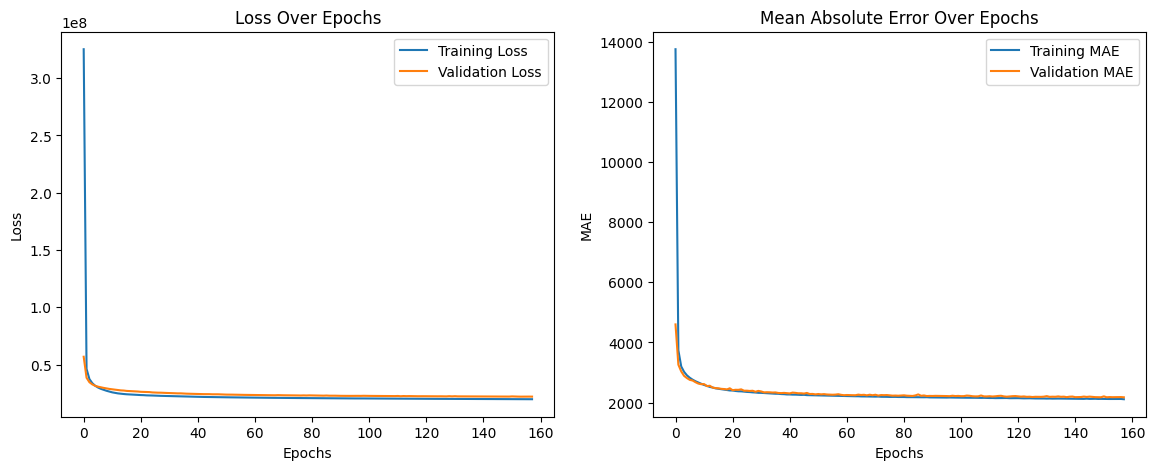

In [ ]:
plot_metrics(history)

Let's test the neural network on the Test Set

In [ ]:
evaluate_performance(first_model, dataset_test_scaled, prices_test)

Test Loss: 21130508.0000
Test MAE: 2185.2361


In [ ]:
first_model_predictions = first_model.predict(dataset_test).flatten()

print(f'Dimensioni di dataset_test_scaled: {dataset_test.shape}')
print(f'Dimensioni di prices_test: {prices_test.shape}')
print(f'Dimensione di first_model_predictions: {first_model_predictions.shape}')

print(first_model_predictions)


#first_model_mea = mean_absolute_error(prices_test.flatten(), first_model_predictions)
#printf(f'MEA on test set for the first model: {first_model_mea}')

259/259 [==============================] - 1s 2ms/step
Dimensioni di dataset_test_scaled: (8262, 111)
Dimensioni di prices_test: (8262,)
Dimensione di first_model_predictions: (413100,)
[28931418. 28919850. 28940202. ... 21252998. 21250942. 21244814.]
